## Índice

- [Importación de los datos](#importación-de-los-datos)
- [Preprocesamiento](#preprocesamiento)
- [Entrenamiento](#entrenamiento)
- [Análisis del modelo](#análisis-del-modelo)
- [Registro del modelo en MLflow](#registro-del-modelo-en-mlflow)

In [1]:
import time
import mlflow
import pandas as pd
from evaluation.evaluator import Evaluator

SEED = 22 # replicabilidad

# =====================================
MODEL_NAME = "RANDOM FOREST MODEL" # Rellenar
# =====================================

/Users/yushanyang/Desktop/PD2/src/models/evaluation/evaluator.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


## Importación de los datos

In [2]:
df_train = pd.read_parquet("../data/train.parquet")
df_test = pd.read_parquet("../data/test.parquet")

# ! NOTA -> están el ICAO, Callsign y Timestamp por si hay que depurar
X_train, y_train = df_train.drop(columns="takeoff_time", axis=1), df_train["takeoff_time"]
X_test, y_test = df_test.drop(columns="takeoff_time", axis=1), df_test["takeoff_time"]

In [3]:
X_train.shape, X_test.shape

((123733, 60), (27791, 60))

In [4]:
X_train.columns


Index(['timestamp', 'icao', 'callsign', 'holding_point', 'runway', 'operator',
       'turbulence_category', 'last_min_takeoffs', 'last_min_landings',
       'last_event_turb_cat', 'time_since_last_event_seconds',
       'time_before_holding_point', 'time_at_holding_point', 'hour', 'weekday',
       'is_holiday', 'Z1', 'KA6', 'KA8', 'K3', 'K2', 'K1', 'Y1', 'Y2', 'Y3',
       'Y7', 'Z6', 'Z4', 'Z2', 'Z3', 'LF', 'L1', 'LA', 'LB', 'LC', 'LD', 'LE',
       '36R_18L', '32R_14L', '36L_18R', '32L_14R', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'precipitation (mm)',
       'snowfall (cm)', 'weather_code (wmo code)', 'surface_pressure (hPa)',
       'cloud_cover (%)', 'cloud_cover_low (%)', 'cloud_cover_mid (%)',
       'cloud_cover_high (%)', 'is_day ()', 'wind_speed_10m (km/h)',
       'wind_direction_10m (°)', 'wind_direction_100m (°)',
       'soil_moisture_0_to_7cm (m³/m³)', 'soil_temperature_100_to_255cm (°C)',
       'soil_moisture_100_to_255cm (m³/m³

In [5]:
X_train.head(4)

,timestamp,icao,callsign,holding_point,runway,operator,turbulence_category,last_min_takeoffs,last_min_landings,last_event_turb_cat,...,cloud_cover_mid (%),cloud_cover_high (%),is_day (),wind_speed_10m (km/h),wind_direction_10m (°),wind_direction_100m (°),soil_moisture_0_to_7cm (m³/m³),soil_temperature_100_to_255cm (°C),soil_moisture_100_to_255cm (m³/m³),et0_fao_evapotranspiration (mm)
0,2024-11-07 05:02:26.219,4CAC23,RYR99AM_,Z4,36L/18R,RYR,Light,0,1,Medium 1,...,0,0,0,6.0,3,41,0.316,20.4,0.164,0.0
1,2024-11-07 05:02:26.721,4CAC23,RYR99AM_,Z4,36L/18R,RYR,Light,0,1,Medium 1,...,0,0,0,6.0,3,41,0.316,20.4,0.164,0.0
2,2024-11-07 05:02:34.900,4CAC23,RYR99AM_,Z4,36L/18R,RYR,Light,0,1,Medium 1,...,0,0,0,6.0,3,41,0.316,20.4,0.164,0.0
3,2024-11-07 05:02:35.399,4CAC23,RYR99AM_,Z4,36L/18R,RYR,Light,0,1,Medium 1,...,0,0,0,6.0,3,41,0.316,20.4,0.164,0.0


In [6]:
X_train['timestamp']

0        2024-11-07 05:02:26.219
1        2024-11-07 05:02:26.721
2        2024-11-07 05:02:34.900
3        2024-11-07 05:02:35.399
4        2024-11-07 05:02:35.706
                   ...          
124159   2025-01-14 19:59:59.993
124160   2025-01-14 22:29:01.359
124161   2025-01-14 22:29:06.417
124162   2025-01-14 22:29:11.578
124163   2025-01-14 22:29:16.437
Name: timestamp, Length: 123733, dtype: datetime64[ns]

Este código define una clase llamada SlidingWindowSplitter, que es un tipo personalizado de validación cruzada basado en ventanas de tiempo (sliding window).
Sirve para conjuntos de datos donde el tiempo importa, como series temporales.

- Constructor (__init__):

Recibe dos parámetros:

window_size_days: duración del conjunto de entrenamiento en días.

step_size_days: cada cuántos días se mueve la ventana hacia adelante.

- split(X, y=None, groups=None):

Convierte la columna timestamp de X en formato de fechas.

Recorre los datos en ventanas deslizantes:

Entrena con todos los datos anteriores a un current_end.

Valida con los datos inmediatamente siguientes (del tamaño step_size_days).

Devuelve los índices de entrenamiento y validación en cada iteración.

- get_n_splits(X, y, groups):

Calcula cuántas ventanas de entrenamiento/validación se podrán hacer con los datos.



In [7]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np 

class SlidingWindowSplitter(BaseCrossValidator):
    def __init__(self, window_size_days, step_size_days):
        self.window_size_days = window_size_days
        self.step_size_days = step_size_days

    def split(self, X, y=None, groups=None):
        timestamps = pd.to_datetime(X['timestamp'])  # asegura formato timestamp
        start_date = timestamps.min()
        end_date = timestamps.max()

        current_start = start_date

        indices = np.arange(len(X))

        while current_start + pd.Timedelta(days=self.window_size_days) <= end_date:
            current_end = current_start + pd.Timedelta(days=self.window_size_days)

            # Creamos máscaras booleanas sobre timestamps
            train_mask = timestamps < current_end
            val_mask = (timestamps >= current_end) & (timestamps < current_end + pd.Timedelta(days=self.step_size_days))

            # Usamos las máscaras para sacar los índices relativos
            train_idx = indices[train_mask.values]
            val_idx = indices[val_mask.values]

            yield train_idx, val_idx

            current_start += pd.Timedelta(days=self.step_size_days)


    def get_n_splits(self, X=None, y=None, groups=None):
        timestamps = pd.to_datetime(X['timestamp'])
        start_date = timestamps.min()
        end_date = timestamps.max()

        n_splits = 0
        current_start = start_date

        while current_start + pd.Timedelta(days=self.window_size_days) <= end_date:
            n_splits += 1
            current_start += pd.Timedelta(days=self.step_size_days)

        return n_splits


In [8]:
sliding_cv = SlidingWindowSplitter(window_size_days=15, step_size_days=15)


## Preprocesamiento

In [9]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

* Preprocesamiento automático de los datos:

cat_cols: selecciona las columnas categóricas (tipo object) de X_train.

num_cols: selecciona las columnas numéricas (int64 o float64) de X_train.

Luego se crea un ColumnTransformer llamado preprocessor que:

Aplica OneHotEncoder a las columnas categóricas (cat_cols), para convertir las categorías en columnas binarias (0 o 1).

Deja pasar las columnas numéricas sin cambios (passthrough)

En Random Forest no necesita un preprocesamiento agresivo porque:

No requiere escalar las variables numéricas (no le importa si una variable está entre 0-1 o 0-10000).

Tolera variables categóricas codificadas tipo one-hot (aunque no trabaja directamente con strings, de ahí el OneHotEncoder).

Es robusto a outliers y distribuciones raras en los datos.

In [10]:
# Eliminar identificadores de X_train y X_test
cols_to_drop = ['icao', 'callsign']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Crear preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

## Entrenamiento

In [11]:
rf = RandomForestRegressor(random_state=SEED)

# Crear pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

# Definir hiperparámetros para GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__max_features': ['sqrt', 0.5],
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=sliding_cv,    
    scoring='neg_mean_absolute_error',
    verbose=3,
    n_jobs=-1
)



In [12]:
start_time = time.time()

# ========================================
# ENTRENAMIENTO AQUÍ
grid_search.fit(X_train, y_train)
# ========================================

end_time = time.time()
execution_time = end_time - start_time

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV 1/4] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-65.908 total time=   6.1s
[CV 2/4] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-72.599 total time=   9.7s
[CV 1/4] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100;, score=-66.133 total time=   4.7s
[CV 1/4] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-65.943 total time=  11.8s
[CV 3/4] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=2, regressor__n_estimators=100;, s

/Applications/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/4] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-65.937 total time=  50.7s
[CV 2/4] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=200;, score=-71.323 total time= 4.7min
[CV 2/4] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-71.406 total time= 2.4min
[CV 4/4] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=1, regressor__min_samples_split=5, regressor__n_estimators=100;, score=-82.557 total time= 9.9min
[CV 1/4] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__min_samples_leaf=2, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-65.853 total time= 1.7min
[CV 3/4] END regress

## Análisis del modelo

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Inicializar listas para almacenar las métricas
mae_train_list = []
rmse_train_list = []

mae_val_list = []
rmse_val_list = []

# Asumiendo que `sliding_cv` es tu objeto SlidingWindowSplitter previamente definido
for train_idx, val_idx in sliding_cv.split(X_train):

    # Seleccionar las particiones de entrenamiento y validación
    X_train_fold = X_train.iloc[train_idx].drop(columns="takeoff_time", errors='ignore')
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx].drop(columns="takeoff_time", errors='ignore')
    y_val_fold = y_train.iloc[val_idx]

    # Entrenamiento y predicciones
    # Si ya has hecho un `grid_search.fit(X_train, y_train)`, usas el mejor modelo de la búsqueda.
    y_pred_train_fold = grid_search.best_estimator_.predict(X_train_fold)
    y_pred_val_fold = grid_search.best_estimator_.predict(X_val_fold)

    # Calcular las métricas para cada fold
    mae_train_fold = mean_absolute_error(y_train_fold, y_pred_train_fold)
    rmse_train_fold = np.sqrt(mean_squared_error(y_train_fold, y_pred_train_fold))

    mae_val_fold = mean_absolute_error(y_val_fold, y_pred_val_fold)
    rmse_val_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold))

    # Guardar las métricas por fold
    mae_train_list.append(mae_train_fold)
    rmse_train_list.append(rmse_train_fold)
    mae_val_list.append(mae_val_fold)
    rmse_val_list.append(rmse_val_fold)

# Promediar las métricas sobre todas las ventanas
mae_train = np.mean(mae_train_list)
rmse_train = np.mean(rmse_train_list)

mae_val = np.mean(mae_val_list)
rmse_val = np.mean(rmse_val_list)

# Mostrar los resultados
print(f"MAE (Entrenamiento): {mae_train:.4f}")
print(f"RMSE (Entrenamiento): {rmse_train:.4f}")
print(f"MAE (Validación): {mae_val:.4f}")
print(f"RMSE (Validación): {rmse_val:.4f}")


MAE (Entrenamiento): 0.9552
RMSE (Entrenamiento): 3.3772
MAE (Validación): 1.0856
RMSE (Validación): 3.8271


In [18]:
# ===============================================================
# Generar predicciones en test
y_pred = grid_search.best_estimator_.predict(X_test)
# ===============================================================

df_test['prediction'] = y_pred

In [19]:
# Nota: df_test tiene que tener la columna 'prediction'
ev = Evaluator(df_test, MODEL_NAME, mae_val, rmse_val)
report = ev.getReport()
ev.visualEvaluation()

### Influencia de las variables

In [21]:
# Sacar el preprocessor ya entrenado del pipeline
trained_preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Ahora sí: obtener los nombres de las variables codificadas
encoded_cat_cols = trained_preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Obtener los nombres de todas las características
all_feature_names = np.concatenate([encoded_cat_cols, num_cols])  # O num_cols + list(encoded_cat_cols)

# Comprobar que las longitudes coinciden
if len(feature_importance) != len(all_feature_names):
    print(f"Error: La longitud de las importancias de características ({len(feature_importance)}) no coincide con el número de características ({len(all_feature_names)})")

# Crear el DataFrame de importancia
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)



                           Feature    Importance
228  time_since_last_event_seconds  6.913354e-02
230          time_at_holding_point  6.571995e-02
229      time_before_holding_point  5.887293e-02
237         surface_pressure (hPa)  3.319631e-02
245        wind_direction_100m (°)  3.267800e-02
..                             ...           ...
109                   operator_JME  2.318716e-07
70                    operator_DIO  1.546239e-07
136                   operator_N20  1.142856e-07
127                   operator_MEA  1.096728e-07
235                  snowfall (cm)  0.000000e+00

[250 rows x 2 columns]


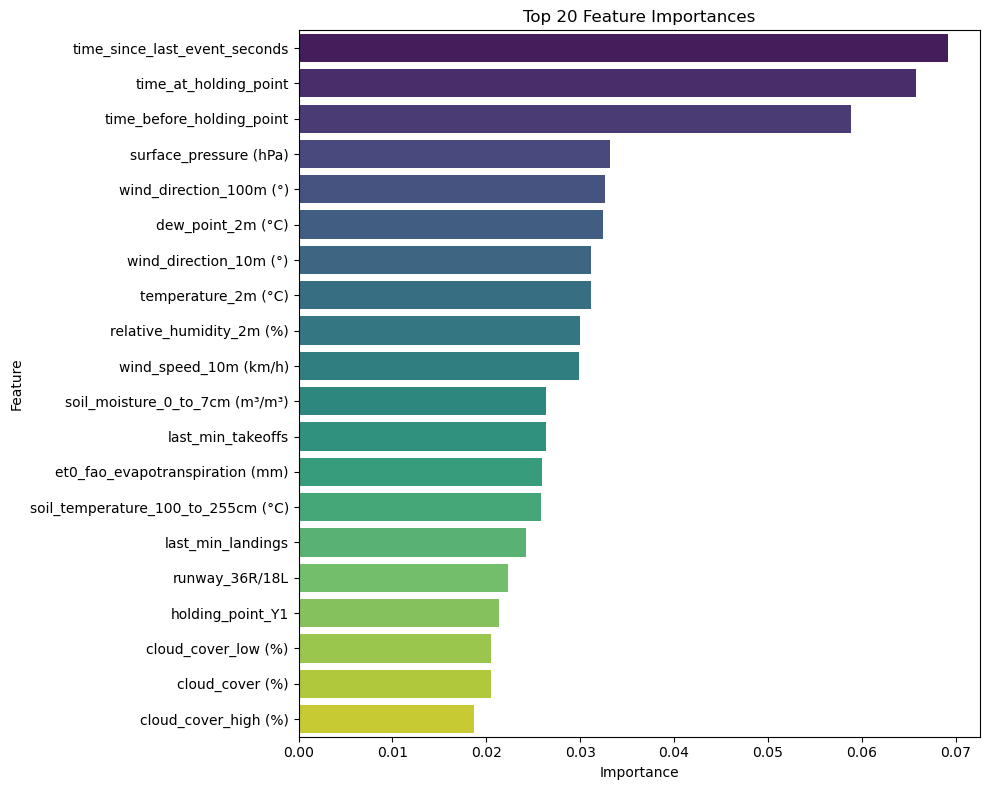

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Elegir las 20 características más importantes
top_features = feature_importance_df.head(20)

# Crear el gráfico
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features,
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()



In [20]:
print(grid_search.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['holding_point', 'runway',
                                                   'operator',
                                                   'turbulence_category',
                                                   'last_event_turb_cat',
                                                   'weekday']),
                                                 ('num', 'passthrough',
                                                  ['last_min_takeoffs',
                                                   'last_min_landings',
                                                   'time_since_last_event_seconds',
                                                   'time_before_holding_point',
                                                   'time_at_holding_point',
           

## Registro del modelo en MLflow

In [23]:
mlflow.set_tracking_uri("file:./mlflow_experiments")
mlflow.set_experiment("takeoff_time_prediction")

with mlflow.start_run():

    # - Datos generales -

    # ========================================================================
    mlflow.set_tag("model_type", "RandomForestRegressor") 
    mlflow.set_tag("framework", "scikit-learn")  
    mlflow.set_tag("target_variable", "takeoff_time")  
    mlflow.set_tag("preprocessing", "OneHotEncoder + passthrough")  # Transforamciones
    mlflow.set_tag("dataset", "original")  # Indica si has modificado el conjunto de datos
    mlflow.set_tag("seed", SEED)  # Semilla para replicabilidad
    # ========================================================================
    
    # - Hiperparámetros óptimos -
    mlflow.log_param("model", "RandomForestRegressor")  # Cambia a tu nombre de modelo
    mlflow.log_param("n_estimators", grid_search.best_params_['regressor__n_estimators'])
    mlflow.log_param("max_depth", grid_search.best_params_['regressor__max_depth'])
    
    # =====================================
    # AÑADIR HIPERPARÁMETROS
    # =====================================
    
    # - Métricas -

    mlflow.log_metric("execution_time_s", execution_time)

    mlflow.log_metric("mae_val", mae_val)
    mlflow.log_metric("rmse_val", rmse_val)

    mlflow.log_metric("mae_train", mae_train)
    mlflow.log_metric("rmse_train", rmse_train)

    # Registrar métricas globales en test
    for metric_name, value in report["global"].items():
        mlflow.log_metric(f"{metric_name}_test", value)
    
    # Registrar métricas por runway
    for runway, metrics in report["by_runway"].items():
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{metric_name}_test_runway_{runway}", value)
    
    # Registrar métricas por holding point
    for hp, metrics in report["by_holding_point"].items():
        for metric_name, value in metrics.items():
            mlflow.log_metric(f"{metric_name}_test_hp_{hp}", value)

    # - Modelo -

    # ========================================================================
    # NOTA - Dependiendo de con qué has hecho el modelo esto hay que cambiarlo
    mlflow.sklearn.log_model(grid_search.best_estimator_, MODEL_NAME)
    # ========================================================================
    

/Applications/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.

